In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from scipy import interpolate
from scipy.stats import pearsonr
%matplotlib inline

In [257]:
df = pd.DataFrame(np.fromfile(
        "./browser_download.bin",
        dtype=np.uint16).astype(np.float32) * (3300 / 2**12))

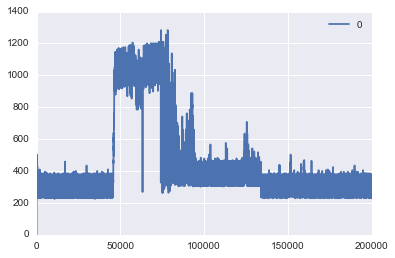

In [368]:
df = pd.DataFrame(np.fromfile(
        "./output.bin",
        dtype=np.uint16).astype(np.float32) * (5000 / 2**10))
df[:].plot()

Группируем по миллисекундам и усредняем:

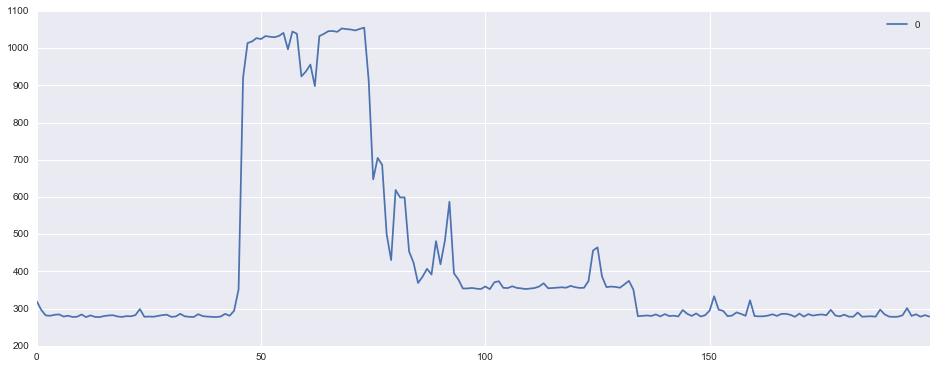

In [369]:
df_r1000 = df.groupby(df.index//1000).mean()
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r1000.plot(ax=ax)

Интересные нам всплески потребления кончаются где-то на 10000-ной миллисекунде (их пять подряд, мы моргали лампочкой пять раз).

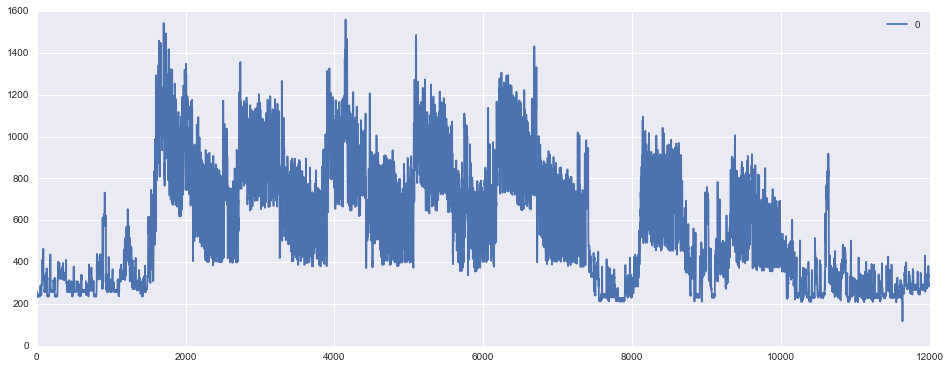

In [4]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()
df_r1000[:12000].plot(ax=ax)

Функции для парсинга событий из лога и поиска точки синхронизации:

In [223]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy import interpolate
from scipy.stats import pearsonr

import logging
log = logging.getLogger(__name__)

def torch_status(lines):
    """
    Parse torch statuses from lines
    """
    for line in lines:
        if "newStatus=2" in line:
            yield (
                datetime.strptime(
                    line.split()[1], "%H:%M:%S.%f"),
                1)
        elif "newStatus=1" in line:
            yield (
                datetime.strptime(
                    line.split()[1], "%H:%M:%S.%f"),
                0)

def parse_torch_events(filename, sps=1000):
    """
    Parse torch events from file, considering target sample rate.
    Offset is the number of sample
    """
    log.info("Parsing torch events...")
    with open(filename) as eventlog:
        df = pd.DataFrame.from_records(
            torch_status(eventlog), columns=["offset", "status"])
        df["offset"] = df["offset"].map(
            lambda x: int(np.round((x - df["offset"][0]).total_seconds() * sps)))
        return df

def ref_signal(torch, trailing_zeros=1000):
    """
    Generate square reference signal with trailing zeroes
    """
    log.info("Generating ref signal...")
    f = interpolate.interp1d(torch["offset"], torch["status"], kind="zero")
    X = np.linspace(0, torch["offset"].values[-1], torch["offset"].values[-1])
    return np.append(f(X), np.zeros(trailing_zeros))

def cross_correlate(sig, ref, first=30000):
    """
    Calculate cross-correlation with lag. Take only first n lags.
    """
    log.info("Calculating cross-correlation...")
    lags = np.arange(len(sig) - len(ref))
    if len(lags) > first:
        lags = lags[:first]
    return pd.DataFrame.from_records(
        [pearsonr(sig[lag:lag+len(ref)], ref) for lag in lags],
        columns=["corr", "p_value"])

def sync(sig, eventlog, sps=1000, trailing_zeros=1000, first=30000):
    rs = ref_signal(
        parse_torch_events(eventlog, sps=sps),
        trailing_zeros=trailing_zeros)
    cc = cross_correlate(sig, rs)
    sync_point = np.argmax(cc["corr"])
    if cc["p_value"][sync_point] > 0.05:
        raise RuntimeError("P-value is too big: %d" % cc["p_value"][sync_point])
    log.info(
       "Pearson's coef: %d, p-value: %d",
       cc["corr"][sync_point],
       cc["p_value"][sync_point])
    return sync_point
    

In [237]:
te = parse_torch_events("browser_download.log", sps=1000)
rs = ref_signal(te)
cc = cross_correlate(df_r1000[0], rs)

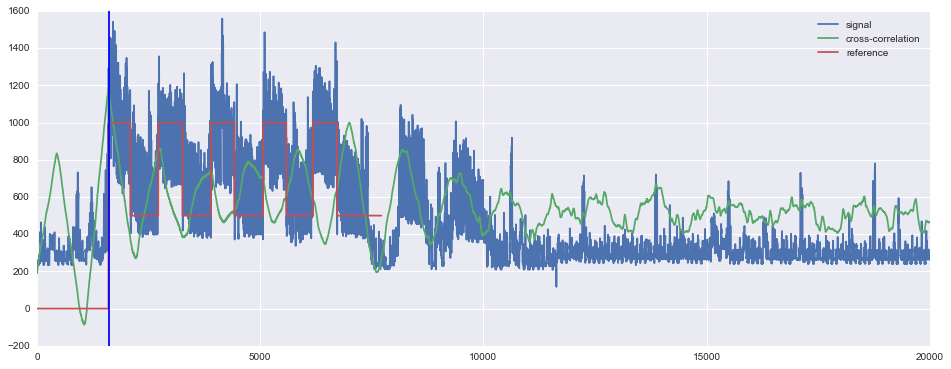

In [241]:
fig = sns.plt.figure(figsize=(16, 6))
ax = sns.plt.subplot()

sns.plt.plot(df_r1000[0][:20000], label="signal")
sns.plt.plot(cc["corr"][:20000]*1000 + 500, label="cross-correlation")
sns.plt.plot(np.append(np.zeros(sync_point), rs * 500 + 500), label="reference")
#sns.plt.plot(cc["p_value"][:20000]*1000, label="p-value")
sync_point = np.argmax(cc["corr"])
sns.plt.axvline(sync_point)
ax.legend()

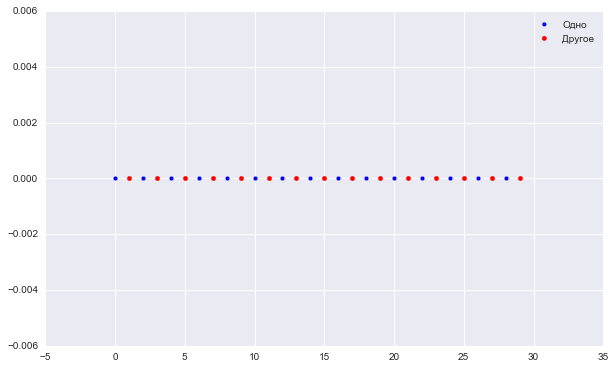

In [343]:
fig = sns.plt.figure(figsize=(10, 6))
ax = sns.plt.subplot()
sns.plt.scatter(np.arange(0, 30, 2), np.zeros(15), label="Одно")
sns.plt.scatter(np.arange(1, 31, 2), np.zeros(15), label="Другое", color="red")
ax.legend()